# **Análise de Danos em Veículos Utilizando Segmentação de Peças e Classificação Fracamente Supervisionada**

O problema que se pretende resolver é a automatização da análise de danos visíveis em veículos, que será dividida em duas etapas principais:

1.   Segmentação das peças isoladamente do carro (parachoques, portas, capô, etc.) utilizando YOLOv11;
2.   Classificação do nível de avaria em cada peça detectada a partir de seu bounding box. (nenhuma, leve, média, alta)

A ideia é entregar um sistema capaz de, a partir de uma imagem do veículo, identificar as regiões danificadas e estimar a gravidade dos danos.

## 1. Aquisição do dataset
O dataset escolhido foi o [car-parts-and-car-damages](https://www.kaggle.com/datasets/humansintheloop/car-parts-and-car-damages) que possui 998 segmentadas por peça

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("humansintheloop/car-parts-and-car-damages")

print("Path to dataset files:", path)

100%|██████████| 2.89G/2.89G [01:15<00:00, 41.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/humansintheloop/car-parts-and-car-damages/versions/2


In [ ]:
!pip3 install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
!cp -r /root/.cache/kagglehub/datasets/humansintheloop/car-parts-and-car-damages/versions/2 /content/

In [ ]:
# Verifica as extensões de imagens presentes no dataset
# Conta quantas imagens estão presentes

import os

def extensions(dir):
    exts = set()
    for file in os.listdir(dir):
        if os.path.isfile(os.path.join(dir, file)):
            _, extension = os.path.splitext(file)
            if extension:
                exts.add(extension)
    return exts

path = "/content/2/Car damages dataset/File1/img/"
found_extensions_img = extensions(path)
file_count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])

print(f"Extensions image found: {found_extensions_img}")
print(f"Total image files: {file_count}")

Extensions image found: {'.jpg', '.png'}
Total image files: 998


In [ ]:
path = "/content/2/Car damages dataset/File1/ann"
file_count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
found_extensions_json = extensions(path)

print(f"Extensions label found: {found_extensions_json}")
print(f"Total label files: {file_count}")

Extensions label found: {'.json'}
Total label files: 998


In [ ]:
!cat /content/2/Car\ damages\ dataset/File1/ann/Car\ damages\ 100.png.json

{
    "tags": [],
    "description": "",
    "objects": [
        {
            "id": 1164155991,
            "classId": 11380334,
            "description": "",
            "geometryType": "polygon",
            "labelerLogin": "GhazalehHITL",
            "createdAt": "2023-01-18T10:58:10.147Z",
            "updatedAt": "2023-01-18T10:58:10.147Z",
            "tags": [],
            "classTitle": "Back-bumper",
            "points": {
                "exterior": [
                    [
                        523.0,
                        202.0
                    ],
                    [
                        527.0,
                        201.0
                    ],
                    [
                        540.0,
                        200.0
                    ],
                    [
                        547.0,
                        200.0
                    ],
                    [
                        554.0,
                        198.0
                    ],


## Visualização randomica de 4 imagens

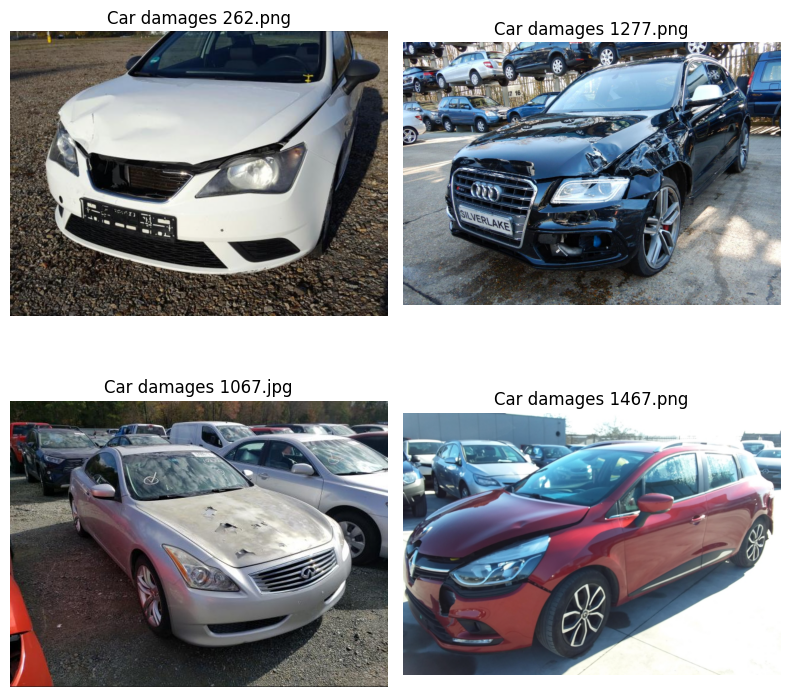

In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def show_random_images(path, n=4):
    image_files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png'))]

    if len(image_files) < n:
        raise ValueError(f"Not enough images in path: found {len(image_files)}, expected at least {n}")

    selected = random.sample(image_files, n)

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = axs.flatten()

    for ax, file in zip(axs, selected):
        img = Image.open(os.path.join(path, file))
        ax.imshow(img)
        ax.set_title(file)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

path = "/content/2/Car damages dataset/File1/img/"
show_random_images(path)

## Criando dataset de treinamento padrão YOLO

In [ ]:
!mkdir dataset && \
mkdir dataset/images && \
mkdir dataset/labels && \
mkdir dataset/images/train && \
mkdir dataset/images/val && \
mkdir dataset/labels/train && \
mkdir dataset/labels/val

## Renomeia os dados deixando apenas número de identificação e move para path dataset

In [ ]:
!rm -r /content/dataset

In [ ]:
import re
import os

valid_exts = found_extensions_img

def rename_images(image_dir, new_image_dir):
  for filename in os.listdir(image_dir):
      name, ext = os.path.splitext(filename)
      if ext.lower() in valid_exts:
          # Extrai apenas os números do nome do arquivo
          numbers = re.findall(r'\d+', name)
          if numbers:
              new_name = f"{numbers[-1]}{ext.lower()}"
              old_path = os.path.join(image_dir, filename)
              new_path = os.path.join(new_image_dir, new_name)
              os.rename(old_path, new_path)
              print(f"Renamed: {image_dir}/{filename} -> {new_image_dir}/{new_name}")
          else:
              print(f"'{filename}' does not contain numbers, ignoring...")

def rename_labels(label_dir, new_label_dir):
    for file in os.listdir(label_dir):
        if file.startswith("Car damages ") and (file.endswith(".png.json") or file.endswith(".jpg.json")):
            # Remove the prefix
            remaining_name = file[len("Car damages "):]

            # Strip the file extension
            if remaining_name.endswith(".png.json"):
                number = remaining_name[:-len(".png.json")]
            elif remaining_name.endswith(".jpg.json"):
                number = remaining_name[:-len(".jpg.json")]

            # Make sure the extracted part is a number
            if number.isdigit():
                new_name = f"{number}.json"
                old_path = os.path.join(label_dir, file)
                new_path = os.path.join(new_label_dir, new_name)

                # Rename the file
                os.rename(old_path, new_path)
                print(f"Renamed: {label_dir}/{file} -> {new_label_dir}/{new_name}")

image_dir = '/content/2/Car damages dataset/File1/img'
new_image_dir = '/content/dataset/images'
rename_images(image_dir, new_image_dir)

rename_labels('/content/2/Car damages dataset/File1/ann', '/content/dataset/labels')

Renamed: /content/2/Car damages dataset/File1/img/Car damages 1057.png -> /content/dataset/images/1057.png
Renamed: /content/2/Car damages dataset/File1/img/Car damages 1664.png -> /content/dataset/images/1664.png
Renamed: /content/2/Car damages dataset/File1/img/Car damages 251.png -> /content/dataset/images/251.png
Renamed: /content/2/Car damages dataset/File1/img/Car damages 1345.png -> /content/dataset/images/1345.png
Renamed: /content/2/Car damages dataset/File1/img/Car damages 254.png -> /content/dataset/images/254.png
Renamed: /content/2/Car damages dataset/File1/img/Car damages 1499.jpg -> /content/dataset/images/1499.jpg
Renamed: /content/2/Car damages dataset/File1/img/Car damages 337.png -> /content/dataset/images/337.png
Renamed: /content/2/Car damages dataset/File1/img/Car damages 114.jpg -> /content/dataset/images/114.jpg
Renamed: /content/2/Car damages dataset/File1/img/Car damages 1460.png -> /content/dataset/images/1460.png
Renamed: /content/2/Car damages dataset/File1

## Cria data.yaml a partir de meta.json contendo as classes de segmentação

In [ ]:
import json
import yaml

def create_data_yaml(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Extract class names
    class_names = [cls['title'] for cls in data.get('classes', [])]
    print(class_names)
    # Prepare YOLO data.yaml structure
    yolo_data = {
        'train': 'dataset/images/train',
        'val': 'dataset/images/val',
        'nc': len(class_names),
        'names': class_names
    }

    # Save as data.yaml
    with open("data.yaml", 'w') as f:
        yaml.dump(yolo_data, f, sort_keys=False)

    print(f"YOLO data.yaml created with {len(class_names)} classes.")

# Example usage
json_file = '/content/2/Car damages dataset/meta.json'  # Replace with your actual file path
create_data_yaml(json_file)


['Quarter-panel', 'Front-wheel', 'Back-window', 'Trunk', 'Front-door', 'Rocker-panel', 'Grille', 'Windshield', 'Front-window', 'Back-door', 'Headlight', 'Back-wheel', 'Back-windshield', 'Hood', 'Fender', 'Tail-light', 'License-plate', 'Front-bumper', 'Back-bumper', 'Mirror', 'Roof']
YOLO data.yaml created with 21 classes.


## Converte as anotações JSON para txt padrão YOLO

In [ ]:
!rm -r /content/2

In [ ]:
!ls /content/dataset/images | wc -l

1000


In [ ]:
import argparse
from PIL import Image
import glob
import json

def load_yaml_classes(yaml_file):
    with open(yaml_file, 'r') as f:
        yaml_data = yaml.safe_load(f)

    class_mapping = {}
    for idx, name in enumerate(yaml_data.get("names", [])):
        class_mapping[name] = idx

    return class_mapping

def find_image_file(json_file):

    base_name = os.path.splitext(os.path.basename(json_file))[0]
    dir_path = "/content/dataset/images/"

    # Padrões comuns para arquivos de imagem
    patterns = [
        f"{base_name}.*",  # mesmo nome, qualquer extensão
        f"*{base_name}.*"  # nome como parte do arquivo
    ]

    image_extensions = found_extensions_img

    for pattern in patterns:
        for file_path in glob.glob(os.path.join(dir_path, pattern)):
            if any(file_path.lower().endswith(ext) for ext in image_extensions):
                return file_path

    # Tenta encontrar pelo número da imagem, se presente no nome do arquivo JSON
    # Por exemplo: img_1234.json -> 1234.jpg ou image1234.png
    numbers = re.findall(r'\d+', base_name)
    if numbers:
        for num in numbers:
            for ext in image_extensions:
                potential_files = glob.glob(os.path.join(dir_path, f"*{num}*{ext}"))
                if potential_files:
                    return potential_files[0]

    return None

def json_to_yolov11(json_file, output_dir, yaml_file=None, image_file=None):
    # Criar diretório de saída se não existir
    os.makedirs(output_dir, exist_ok=True)

    # Carregar o JSON
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Extrair nome base do arquivo
    base_name = os.path.splitext(os.path.basename(json_file))[0]
    output_file = os.path.join(output_dir, f"{base_name}.txt")

    # Determinar as dimensões da imagem
    image_width, image_height = 640, 640  # valores padrão

    # Se o arquivo de imagem não foi especificado, tenta encontrá-lo
    if not image_file:
        image_file = find_image_file(json_file)

    # Se encontrou a imagem, pega as dimensões reais
    if image_file and os.path.exists(image_file):
        try:
            with Image.open(image_file) as img:
                image_width, image_height = img.size
                print(f"Dimensões da imagem: {image_width}x{image_height}")
        except Exception as e:
            print(f"Erro ao abrir a imagem: {e}")
            print("Usando dimensões padrão: 640x640")
    else:
        print("Imagem não encontrada. Usando dimensões padrão: 640x640")

    # Dicionário para mapear classTitle para ID de classe
    if yaml_file and os.path.exists(yaml_file):
        # Usar o mapeamento do arquivo YAML
        class_mapping = load_yaml_classes(yaml_file)
        print(f"Usando mapeamento de classes do arquivo YAML: {yaml_file}")
    else:
        # Criar mapeamento baseado no arquivo JSON
        class_mapping = {}
        for obj in data.get("objects", []):
            class_title = obj.get("classTitle")
            if class_title not in class_mapping:
                class_mapping[class_title] = len(class_mapping)
        print("Mapeamento de classes criado a partir do JSON")

    # Abrir arquivo de saída
    with open(output_file, 'w') as f:
        for obj in data.get("objects", []):
            class_title = obj.get("classTitle")

            # Verificar se a classe existe no mapeamento
            if class_title not in class_mapping:
                print(f"AVISO: Classe '{class_title}' não encontrada no mapeamento. Ignorando objeto.")
                continue

            class_id = class_mapping[class_title]

            # Obter pontos do polígono e normalizá-los
            points = obj.get("points", {}).get("exterior", [])
            normalized_points = []

            for point in points:
                x, y = point
                # Normalizar para o intervalo [0, 1]
                normalized_x = x / image_width
                normalized_y = y / image_height
                normalized_points.extend([normalized_x, normalized_y])

            # Formato YOLOv11: <class_id> <x1> <y1> <x2> <y2> ... <xn> <yn>
            line = f"{class_id} " + " ".join([f"{p:.6f}" for p in normalized_points])
            f.write(line + "\n")

    os.remove(json_file)

    print(f"Conversão concluída. Arquivo salvo em: {output_file}")

def process_directory(input_dir, output_dir, yaml_file=None):

    # Criar diretório de saída se não existir
    os.makedirs(output_dir, exist_ok=True)

    # Encontrar todos os arquivos JSON no diretório
    json_files = glob.glob(os.path.join(input_dir, "*.json"))

    if not json_files:
        print(f"Nenhum arquivo JSON encontrado em {input_dir}")
        return

    print(f"Encontrados {len(json_files)} arquivos JSON para processar")

    for json_file in json_files:
        print(f"Processando: {os.path.basename(json_file)}")
        json_to_yolov11(json_file, output_dir, yaml_file)

    print(f"Processamento em lote concluído. {len(json_files)} arquivos convertidos.")

process_directory("/content/dataset/labels", "/content/dataset/labels", "/content/data.yaml")

Encontrados 998 arquivos JSON para processar
Processando: 736.json
Dimensões da imagem: 572x397
Usando mapeamento de classes do arquivo YAML: /content/data.yaml
Conversão concluída. Arquivo salvo em: /content/dataset/labels/736.txt
Processando: 1666.json
Dimensões da imagem: 836x596
Usando mapeamento de classes do arquivo YAML: /content/data.yaml
Conversão concluída. Arquivo salvo em: /content/dataset/labels/1666.txt
Processando: 1181.json
Dimensões da imagem: 635x474
Usando mapeamento de classes do arquivo YAML: /content/data.yaml
Conversão concluída. Arquivo salvo em: /content/dataset/labels/1181.txt
Processando: 169.json
Dimensões da imagem: 659x372
Usando mapeamento de classes do arquivo YAML: /content/data.yaml
Conversão concluída. Arquivo salvo em: /content/dataset/labels/169.txt
Processando: 341.json
Dimensões da imagem: 796x598
Usando mapeamento de classes do arquivo YAML: /content/data.yaml
Conversão concluída. Arquivo salvo em: /content/dataset/labels/341.txt
Processando: 165

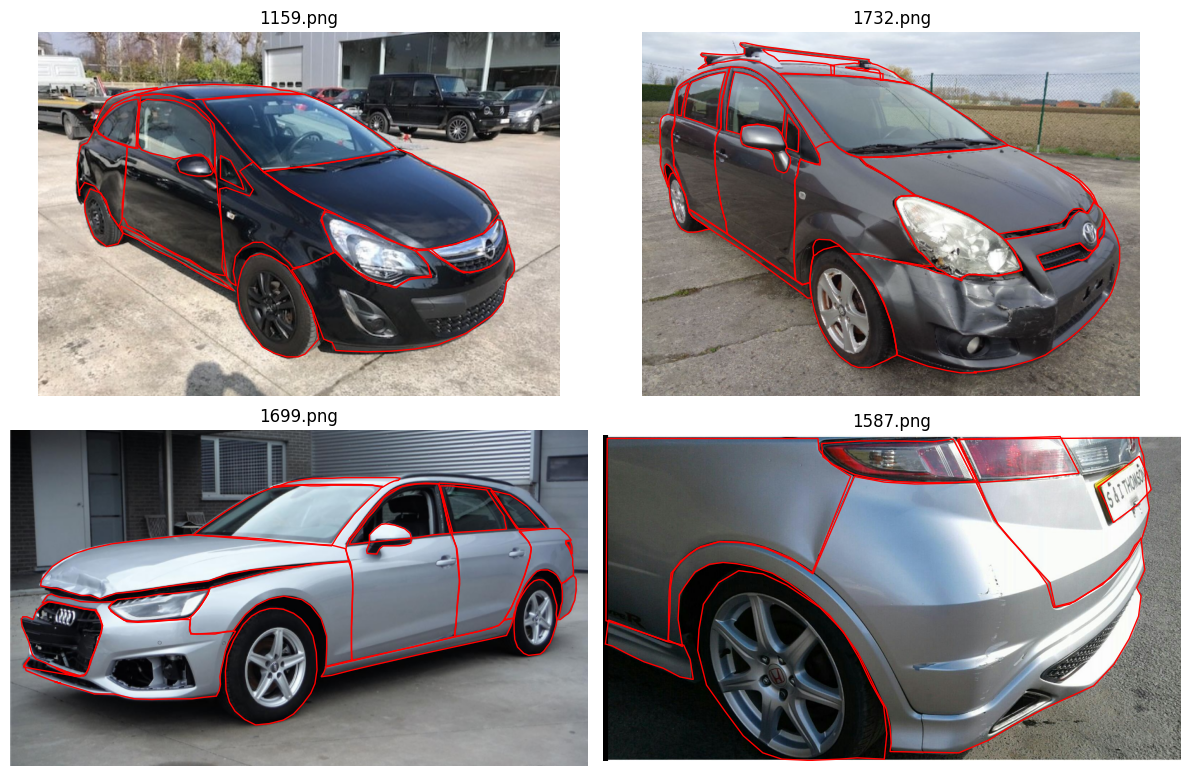

In [ ]:
import matplotlib.patches as patches
from matplotlib.patches import Polygon

image_dir = '/content/dataset/images'
label_dir = '/content/dataset/labels'

# Função para desenhar a segmentação em uma imagem
def draw_segmentation(ax, label_path, image_width, image_height):
    with open(label_path, 'r') as f:
        for line in f:
            parts = list(map(float, line.strip().split()))
            class_id = int(parts[0])
            points = parts[1:]
            if len(points) % 2 != 0:
                continue  # Pula se número de coordenadas for ímpar
            polygon = []
            for i in range(0, len(points), 2):
                x = points[i] * image_width
                y = points[i + 1] * image_height
                polygon.append((x, y))
            patch = Polygon(polygon, closed=True, fill=False, edgecolor='red', linewidth=1)
            ax.add_patch(patch)

# Selecionar aleatoriamente 4 imagens
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
selected_files = random.sample(image_files, 4)

# Criar a figura com subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, image_file in enumerate(selected_files):
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')

    # Abrir imagem
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(image_file)
    axes[i].axis('off')

    # Desenha segmentações
    draw_segmentation(axes[i], label_path, image.width, image.height)

plt.tight_layout()
plt.show()


## Split do dataset em 80% dos dados para treinamento e 20% para validação

In [ ]:
from sklearn.model_selection import train_test_split
import os
import shutil

def split_dataset(images_path, labels_path, output_path, test_size=0.2):
    image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg') or f.endswith('.png')]

    train_files, val_files = train_test_split(image_files, test_size=test_size, random_state=42)

    for split, files in [('train', train_files), ('val', val_files)]:
        os.makedirs(os.path.join(output_path, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(output_path, 'labels', split), exist_ok=True)

        for f in files:
            base = os.path.splitext(f)[0]
            shutil.move(os.path.join(images_path, f), os.path.join(output_path, 'images', split, f))
            shutil.move(os.path.join(labels_path, base + '.txt'), os.path.join(output_path, 'labels', split, base + '.txt'))

# Use this by providing correct paths

split_dataset('/content/dataset/images', '/content/dataset/labels', '/content/dataset')

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
path = '/content/dataset/images/train'
img_train_len = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
path = '/content/dataset/images/val'
img_val_len = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
path = '/content/dataset/labels/train'
label_train_len = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
path = '/content/dataset/labels/val'
label_val_len = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])

print(f"Images to train: {img_train_len}")
print(f"Images to val: {img_val_len}")
print(f"Labels to train: {label_train_len}")
print(f"Labels to val: {label_val_len}")

Images to train: 0
Images to val: 0
Labels to train: 0
Labels to val: 0


In [ ]:
!tar -czvf /content/drive/MyDrive/CarDamage/dataset.tar.gz /content/dataset

tar: Removing leading `/' from member names
/content/dataset/
/content/dataset/images/
/content/dataset/images/train/
/content/dataset/images/train/1471.png
/content/dataset/images/train/1091.jpg
/content/dataset/images/train/1598.jpg
/content/dataset/images/train/1575.png
/content/dataset/images/train/1476.png
/content/dataset/images/train/1113.png
/content/dataset/images/train/1667.png
/content/dataset/images/train/14.png
/content/dataset/images/train/1151.png
/content/dataset/images/train/1469.png
/content/dataset/images/train/1123.png
/content/dataset/images/train/674.jpg
/content/dataset/images/train/873.png
/content/dataset/images/train/298.png
/content/dataset/images/train/1466.png
/content/dataset/images/train/945.png
/content/dataset/images/train/1084.png
/content/dataset/images/train/146.png
/content/dataset/images/train/1677.png
/content/dataset/images/train/761.png
/content/dataset/images/train/1037.png
/content/dataset/images/train/1064.png
/content/dataset/images/train/85

In [ ]:
!yolo task=segment \
  mode=train \
  model=yolo11s-seg.pt \
  data=/content/dataset/data.yaml \
  epochs=100 \
  batch=32 \
  imgsz=640 \
  project=/content/drive/MyDrive/CarDamageYoloResults \
  name=CarDamage \
  save=True \
  save_period=10

Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=/content/dataset/data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=10, cache=False, device=None, workers=8, project=/content/drive/MyDrive/CarDamageYoloResults, name=CarDamage3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False,

In [ ]:
!tar -xvzf /content/drive/MyDrive/CarDamage/CarDamage.tar.gz -C /content/

content/drive/MyDrive/CarDamageYoloResults/CarDamage/
content/drive/MyDrive/CarDamageYoloResults/CarDamage/weights/
content/drive/MyDrive/CarDamageYoloResults/CarDamage/weights/epoch0.pt
content/drive/MyDrive/CarDamageYoloResults/CarDamage/weights/epoch10.pt
content/drive/MyDrive/CarDamageYoloResults/CarDamage/weights/epoch20.pt

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [ ]:
!yolo task=segment mode=predict model=/content/drive/MyDrive/CarDamageYoloResults/CarDamage3/weights/best.pt source=/content/vw-gol-g5-2867480916.jpg

Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11s-seg summary (fused): 113 layers, 10,074,943 parameters, 0 gradients, 35.3 GFLOPs

image 1/1 /content/vw-gol-g5-2867480916.jpg: 384x640 1 Quarter-panel, 1 Front-wheel, 2 Back-windows, 2 Trunks, 1 Front-door, 1 Rocker-panel, 1 Front-window, 1 Back-door, 1 Headlight, 2 Back-wheels, 1 Back-windshield, 2 Hoods, 1 Fender, 2 Tail-lights, 1 License-plate, 1 Front-bumper, 1 Back-bumper, 1 Mirror, 1 Roof, 1087.7ms
Speed: 6.4ms preprocess, 1087.7ms inference, 277.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


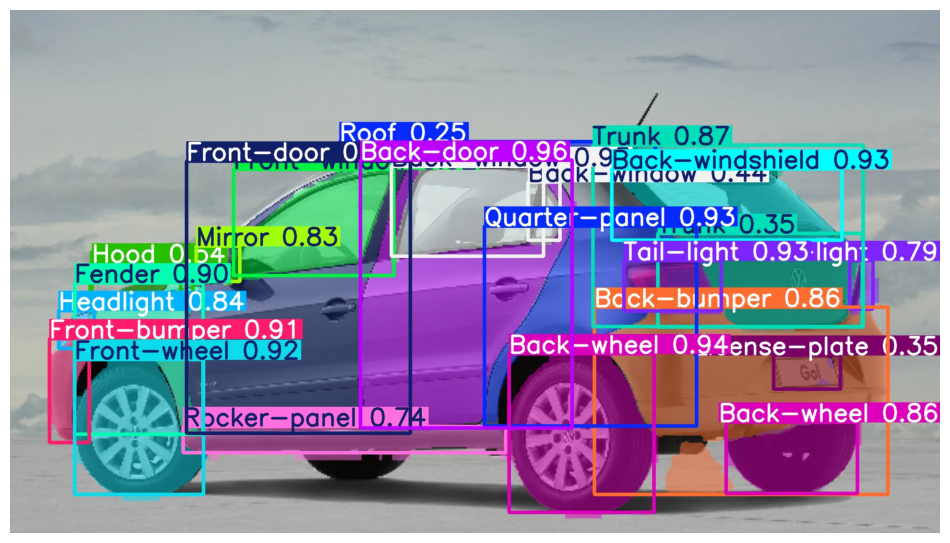

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
fig, axes = plt.subplots(1,1, figsize=(12, 8))

img = Image.open('/content/runs/segment/predict3/vw-gol-g5-2867480916.jpg')

plt.imshow(img)
plt.axis('off')  # remove os eixos
plt.show()

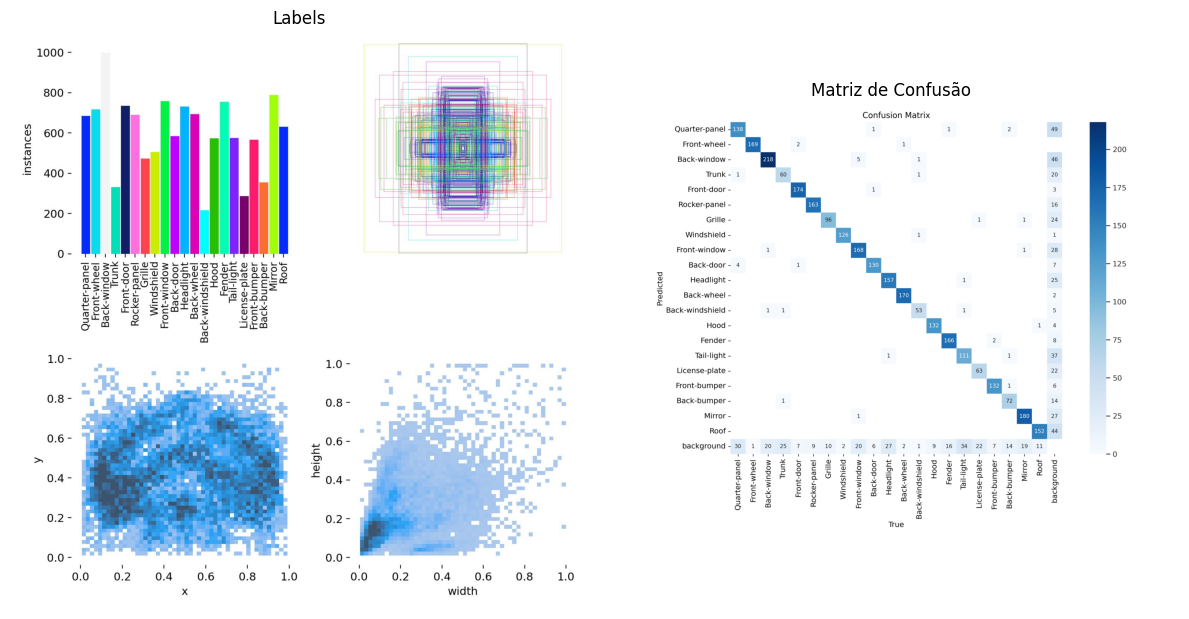

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 8))
axes = axes.flatten()

image = Image.open("/content/drive/MyDrive/CarDamageYoloResults/CarDamage3/labels.jpg")
axes[0].imshow(image)
axes[0].set_title("Labels")
axes[0].axis('off')

image = Image.open("/content/drive/MyDrive/CarDamageYoloResults/CarDamage3/confusion_matrix.png")
axes[1].imshow(image)
axes[1].set_title("Matriz de Confusão")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
!tar -xzvf /content/drive/MyDrive/CarDamage/dataset.tar.gz -C /content/

content/dataset/
content/dataset/images/
content/dataset/images/train/
content/dataset/images/train/1471.png
content/dataset/images/train/1091.jpg
content/dataset/images/train/1598.jpg
content/dataset/images/train/1575.png
content/dataset/images/train/1476.png
content/dataset/images/train/1113.png
content/dataset/images/train/1667.png
content/dataset/images/train/14.png
content/dataset/images/train/1151.png
content/dataset/images/train/1469.png
content/dataset/images/train/1123.png
content/dataset/images/train/674.jpg
content/dataset/images/train/873.png
content/dataset/images/train/298.png
content/dataset/images/train/1466.png
content/dataset/images/train/945.png
content/dataset/images/train/1084.png
content/dataset/images/train/146.png
content/dataset/images/train/1677.png
content/dataset/images/train/761.png
content/dataset/images/train/1037.png
content/dataset/images/train/1064.png
content/dataset/images/train/858.png
content/dataset/images/train/333.png
content/dataset/images/trai

In [ ]:
!rm -r dataset_crops/

In [ ]:
import os
import cv2
import numpy as np
from pathlib import Path
import shutil
from tqdm import tqdm

def create_class_dirs(output_base_path, class_names):
    """Cria diretórios para cada classe."""
    for class_name in class_names:
        class_dir = os.path.join(output_base_path, class_name)
        os.makedirs(class_dir, exist_ok=True)

def parse_yolo_segmentation_file(label_file_path, img_width, img_height):
    """
    Parse um arquivo de segmentação YOLO e retorna as classes e os polígonos.
    Formato do arquivo: class_id x1 y1 x2 y2 ... xn yn
    """
    segments_by_class = {}

    if not os.path.exists(label_file_path):
        return segments_by_class

    with open(label_file_path, 'r') as file:
        lines = file.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:  # Precisa de pelo menos class_id e 2 pontos (4 valores)
                continue

            class_id = int(parts[0])

            # Extrair coordenadas dos pontos do polígono
            polygon_points = []
            for i in range(1, len(parts), 2):
                if i + 1 < len(parts):
                    # Converter de coordenadas normalizadas (0-1) para coordenadas de pixel
                    x = float(parts[i]) * img_width
                    y = float(parts[i + 1]) * img_height
                    polygon_points.append((int(x), int(y)))

            if class_id not in segments_by_class:
                segments_by_class[class_id] = []

            segments_by_class[class_id].append(np.array(polygon_points, dtype=np.int32))

    return segments_by_class

def crop_segmented_objects(image_path, label_path, output_path, class_names):
    """
    Recorta objetos segmentados de uma imagem com base em seus rótulos YOLO.
    """
    # Verificar se a imagem e o arquivo de rótulo existem
    if not os.path.exists(image_path) or not os.path.exists(label_path):
        print(f"Arquivo não encontrado: {image_path} ou {label_path}")
        return 0

    # Ler a imagem
    img = cv2.imread(image_path)
    if img is None:
        print(f"Não foi possível ler a imagem: {image_path}")
        return 0

    height, width = img.shape[:2]

    # Parse o arquivo de segmentação YOLO
    segments_by_class = parse_yolo_segmentation_file(label_path, width, height)

    crops_count = 0
    # Para cada classe e seus segmentos
    for class_id, polygons in segments_by_class.items():
        if class_id >= len(class_names):
            class_name = f"class_{class_id}"
        else:
            class_name = class_names[class_id]

        # Diretório de saída para esta classe
        class_output_dir = os.path.join(output_path, class_name)
        os.makedirs(class_output_dir, exist_ok=True)

        # Nome base da imagem
        image_filename = os.path.basename(image_path)
        base_name = os.path.splitext(image_filename)[0]

        # Para cada polígono desta classe
        for idx, polygon in enumerate(polygons):
            # Criar uma máscara para este polígono
            mask = np.zeros((height, width), dtype=np.uint8)
            cv2.fillPoly(mask, [polygon], 255)

            # Aplicar a máscara à imagem para isolar o objeto
            masked_img = cv2.bitwise_and(img, img, mask=mask)

            # Encontrar os limites do polígono para cropping
            x, y, w, h = cv2.boundingRect(polygon)

            # Recortar a região de interesse
            cropped = masked_img[y:y+h, x:x+w]

            # Adicionar um fundo transparente para áreas fora do polígono
            # Converter para RGBA (adicionar canal alfa)
            b, g, r = cv2.split(cropped)
            alpha = np.zeros_like(b)
            alpha[mask[y:y+h, x:x+w] > 0] = 255
            cropped_rgba = cv2.merge((b, g, r, alpha))

            # Salvar a imagem crop
            output_file = os.path.join(class_output_dir, f"{base_name}_{idx}.png")
            cv2.imwrite(output_file, cropped_rgba)
            crops_count += 1

    return crops_count

def main():
    # Configurações
    dataset_path = "/content/dataset"
    images_dir = os.path.join(dataset_path, "images")
    labels_dir = os.path.join(dataset_path, "labels")
    output_base_path = "dataset_crops"

    # Verificar se os diretórios existem
    if not os.path.exists(images_dir):
        print(f"Diretório de imagens não encontrado: {images_dir}")
        return

    if not os.path.exists(labels_dir):
        print(f"Diretório de labels não encontrado: {labels_dir}")
        return

    # Tentar ler o arquivo data.yaml para obter os nomes das classes
    class_names = []
    data_yaml_path = "/content/data.yaml"

    if os.path.exists(data_yaml_path):
        try:
            import yaml
            with open(data_yaml_path, 'r') as yaml_file:
                data_yaml = yaml.safe_load(yaml_file)
                if 'names' in data_yaml:
                    # O formato pode ser lista ou dicionário
                    if isinstance(data_yaml['names'], list):
                        class_names = data_yaml['names']
                    elif isinstance(data_yaml['names'], dict):
                        # Organize os nomes por índice
                        max_class_id = max(map(int, data_yaml['names'].keys()))
                        class_names = [""] * (max_class_id + 1)
                        for class_id, name in data_yaml['names'].items():
                            class_names[int(class_id)] = name
        except Exception as e:
            print(f"Erro ao ler o arquivo data.yaml: {e}")
            print("Usando nomes genéricos para as classes.")

    # Se não conseguir ler os nomes das classes, use nomes genéricos
    if not class_names:
        # Verificar quantas classes existem analisando os arquivos de label
        max_class_id = 0
        for label_file in os.listdir(labels_dir):
            if not label_file.endswith('.txt'):
                continue

            label_path = os.path.join(labels_dir, label_file)
            with open(label_path, 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    if parts:
                        class_id = int(parts[0])
                        max_class_id = max(max_class_id, class_id)

        # Criar nomes genéricos para as classes
        class_names = [f"class_{i}" for i in range(max_class_id + 1)]

    # Criar diretórios de saída para cada classe
    os.makedirs(output_base_path, exist_ok=True)
    create_class_dirs(output_base_path, class_names)

    print(f"Classes encontradas: {class_names}")

    # Processar cada imagem
    total_crops = 0
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for image_file in tqdm(image_files, desc="Processando imagens"):
        image_path = os.path.join(images_dir, image_file)

        # Encontrar o arquivo de label correspondente
        base_name = os.path.splitext(image_file)[0]
        label_file = f"{base_name}.txt"
        label_path = os.path.join(labels_dir, label_file)

        # Recortar objetos segmentados
        crops = crop_segmented_objects(image_path, label_path, output_base_path, class_names)
        total_crops += crops

    print(f"Processamento concluído! Total de {total_crops} crops salvos em {output_base_path}")

if __name__ == "__main__":
    main()

Classes encontradas: ['Quarter-panel', 'Front-wheel', 'Back-window', 'Trunk', 'Front-door', 'Rocker-panel', 'Grille', 'Windshield', 'Front-window', 'Back-door', 'Headlight', 'Back-wheel', 'Back-windshield', 'Hood', 'Fender', 'Tail-light', 'License-plate', 'Front-bumper', 'Back-bumper', 'Mirror', 'Roof']


Processando imagens: 100%|██████████| 998/998 [00:42<00:00, 23.26it/s]

Processamento concluído! Total de 15767 crops salvos em dataset_crops


## Faz um crop das peças segmentadas e as separa por classes

In [ ]:
import os
import cv2
import numpy as np
from pathlib import Path
import shutil
from tqdm import tqdm

def create_class_dirs(output_base_path, class_names):
    for class_name in class_names:
        class_dir = os.path.join(output_base_path, class_name)
        os.makedirs(class_dir, exist_ok=True)

def parse_yolo_segmentation_file(label_file_path, img_width, img_height):

    segments_by_class = {}

    if not os.path.exists(label_file_path):
        return segments_by_class

    with open(label_file_path, 'r') as file:
        lines = file.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:  # Precisa de pelo menos class_id e 2 pontos (4 valores)
                continue

            class_id = int(parts[0])

            # Extrair coordenadas dos pontos do polígono
            polygon_points = []
            for i in range(1, len(parts), 2):
                if i + 1 < len(parts):
                    # Converter de coordenadas normalizadas (0-1) para coordenadas de pixel
                    x = float(parts[i]) * img_width
                    y = float(parts[i + 1]) * img_height
                    polygon_points.append((int(x), int(y)))

            if class_id not in segments_by_class:
                segments_by_class[class_id] = []

            segments_by_class[class_id].append(np.array(polygon_points, dtype=np.int32))

    return segments_by_class

def crop_segmented_objects(image_path, label_path, output_path, class_names):

    # Verificar se a imagem e o arquivo de rótulo existem
    if not os.path.exists(image_path) or not os.path.exists(label_path):
        print(f"Arquivo não encontrado: {image_path} ou {label_path}")
        return 0

    # Ler a imagem
    img = cv2.imread(image_path)
    if img is None:
        print(f"Não foi possível ler a imagem: {image_path}")
        return 0

    height, width = img.shape[:2]

    # Parse o arquivo de segmentação YOLO
    segments_by_class = parse_yolo_segmentation_file(label_path, width, height)

    crops_count = 0
    # Para cada classe e seus segmentos
    for class_id, polygons in segments_by_class.items():
        if class_id >= len(class_names):
            class_name = f"class_{class_id}"
        else:
            class_name = class_names[class_id]

        # Diretório de saída para esta classe
        class_output_dir = os.path.join(output_path, class_name)
        os.makedirs(class_output_dir, exist_ok=True)

        # Nome base da imagem
        image_filename = os.path.basename(image_path)
        base_name = os.path.splitext(image_filename)[0]

        # Para cada polígono desta classe
        for idx, polygon in enumerate(polygons):
            # Criar uma máscara para este polígono
            mask = np.zeros((height, width), dtype=np.uint8)
            cv2.fillPoly(mask, [polygon], 255)

            # Aplicar a máscara à imagem para isolar o objeto
            masked_img = cv2.bitwise_and(img, img, mask=mask)

            # Encontrar os limites do polígono para cropping
            x, y, w, h = cv2.boundingRect(polygon)

            # Recortar a região de interesse
            cropped = masked_img[y:y+h, x:x+w]

            # Adicionar um fundo transparente para áreas fora do polígono
            # Converter para RGBA (adicionar canal alfa)
            b, g, r = cv2.split(cropped)
            alpha = np.zeros_like(b)
            alpha[mask[y:y+h, x:x+w] > 0] = 255
            cropped_rgba = cv2.merge((b, g, r, alpha))

            # Salvar a imagem crop
            output_file = os.path.join(class_output_dir, f"{base_name}_{idx}.png")
            cv2.imwrite(output_file, cropped_rgba)
            crops_count += 1

    return crops_count

def main():
    # Configurações
    dataset_path = "/content/dataset/"
    images_dir = os.path.join(dataset_path, "images")
    labels_dir = os.path.join(dataset_path, "labels")
    output_base_path = "dataset_crops"

    # Verificar se os diretórios existem
    if not os.path.exists(images_dir):
        print(f"Diretório de imagens não encontrado: {images_dir}")
        return

    if not os.path.exists(labels_dir):
        print(f"Diretório de labels não encontrado: {labels_dir}")
        return

    # Tentar ler o arquivo data.yaml para obter os nomes das classes
    class_names = []
    data_yaml_path = os.path.join(dataset_path, "/content/data.yaml")

    if os.path.exists(data_yaml_path):
        try:
            import yaml
            with open(data_yaml_path, 'r') as yaml_file:
                data_yaml = yaml.safe_load(yaml_file)
                if 'names' in data_yaml:
                    # O formato pode ser lista ou dicionário
                    if isinstance(data_yaml['names'], list):
                        class_names = data_yaml['names']
                    elif isinstance(data_yaml['names'], dict):
                        # Organize os nomes por índice
                        max_class_id = max(map(int, data_yaml['names'].keys()))
                        class_names = [""] * (max_class_id + 1)
                        for class_id, name in data_yaml['names'].items():
                            class_names[int(class_id)] = name
        except Exception as e:
            print(f"Erro ao ler o arquivo data.yaml: {e}")
            print("Usando nomes genéricos para as classes.")

    # Se não conseguir ler os nomes das classes, use nomes genéricos
    if not class_names:
        # Verificar quantas classes existem analisando os arquivos de label
        max_class_id = 0
        for label_file in os.listdir(labels_dir):
            if not label_file.endswith('.txt'):
                continue

            label_path = os.path.join(labels_dir, label_file)
            with open(label_path, 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    if parts:
                        class_id = int(parts[0])
                        max_class_id = max(max_class_id, class_id)

        # Criar nomes genéricos para as classes
        class_names = [f"class_{i}" for i in range(max_class_id + 1)]

    # Criar diretórios de saída para cada classe
    os.makedirs(output_base_path, exist_ok=True)
    create_class_dirs(output_base_path, class_names)

    print(f"Classes encontradas: {class_names}")

    # Processar cada imagem
    total_crops = 0
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    for image_file in tqdm(image_files, desc="Processando imagens"):
        image_path = os.path.join(images_dir, image_file)

        # Encontrar o arquivo de label correspondente
        base_name = os.path.splitext(image_file)[0]
        label_file = f"{base_name}.txt"
        label_path = os.path.join(labels_dir, label_file)

        # Recortar objetos segmentados
        crops = crop_segmented_objects(image_path, label_path, output_base_path, class_names)
        total_crops += crops

    print(f"Processamento concluído! Total de {total_crops} crops salvos em {output_base_path}")

if __name__ == "__main__":
    main()

Classes encontradas: ['Quarter-panel', 'Front-wheel', 'Back-window', 'Trunk', 'Front-door', 'Rocker-panel', 'Grille', 'Windshield', 'Front-window', 'Back-door', 'Headlight', 'Back-wheel', 'Back-windshield', 'Hood', 'Fender', 'Tail-light', 'License-plate', 'Front-bumper', 'Back-bumper', 'Mirror', 'Roof']


Processando imagens: 100%|██████████| 998/998 [00:43<00:00, 23.17it/s]

Processamento concluído! Total de 15767 crops salvos em dataset_crops


In [ ]:
!mkdir test_images_croped

In [ ]:
!cp /content/dataset_crops/Front-door/100_0.png /content/test_images_croped/
!cp /content/dataset_crops/Front-door/101_0.png /content/test_images_croped/

In [ ]:
!zip -r /content/images_croped.zip /content/dataset_crops

Streaming output truncated to the last 5000 lines.
  adding: content/dataset_crops/Mirror/717_0.png (stored 0%)
  adding: content/dataset_crops/Mirror/1380_0.png (stored 0%)
  adding: content/dataset_crops/Mirror/1119_0.png (deflated 0%)
  adding: content/dataset_crops/Mirror/123_0.png (stored 0%)
  adding: content/dataset_crops/Mirror/1096_0.png (stored 0%)
  adding: content/dataset_crops/Mirror/1583_0.png (stored 0%)
  adding: content/dataset_crops/Mirror/852_0.png (stored 0%)
  adding: content/dataset_crops/Mirror/1353_1.png (stored 0%)
  adding: content/dataset_crops/Mirror/1591_0.png (deflated 1%)
  adding: content/dataset_crops/Mirror/1689_0.png (deflated 5%)
  adding: content/dataset_crops/Mirror/906_1.png (stored 0%)
  adding: content/dataset_crops/Mirror/1089_1.png (stored 0%)
  adding: content/dataset_crops/Mirror/1383_0.png (deflated 2%)
  adding: content/dataset_crops/Mirror/1748_0.png (deflated 1%)
  adding: content/dataset_crops/Mirror/1059_0.png (deflated 3%)
  adding: c

In [ ]:
!rm -r dataset_crops/

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
import os
import pandas as pd

def process_image(path):
    original = cv2.imread(path)
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 50, 150)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    sobel_mag = cv2.convertScaleAbs(sobel_mag)

    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')

    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    kernel = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    area_total = sum(cv2.contourArea(c) for c in contours)
    num_regions = len(contours)

    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]

    severity_score = (
        0.5 * min(area_total / (gray.shape[0] * gray.shape[1]), 1.0) +
        0.2 * min(num_regions / 20, 1.0) +
        0.15 * (contrast / 50) +
        0.15 * (np.mean(edges) / 255)
    ) * 10

    return {
        "original": original,
        "edges": edges,
        "sobel_mag": sobel_mag,
        "lbp": lbp,
        "morph": morph,
        "contours": contours,
        "severity_score": severity_score
    }

def plot_and_save_results(image_data, path_out, filename, severity_score):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    axs[0, 0].imshow(cv2.cvtColor(image_data["original"], cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title("Original")

    axs[0, 1].imshow(image_data["edges"], cmap='gray')
    axs[0, 1].set_title("Canny Edges")

    axs[0, 2].imshow(image_data["sobel_mag"], cmap='gray')
    axs[0, 2].set_title("Sobel Magnitude")

    axs[1, 0].imshow(image_data["lbp"], cmap='gray')
    axs[1, 0].set_title("LBP")

    axs[1, 1].imshow(image_data["morph"], cmap='gray')
    axs[1, 1].set_title(f"Regiões detectadas")

    img_copy = image_data["original"].copy()
    cv2.drawContours(img_copy, image_data["contours"], -1, (0, 255, 0), 1)
    axs[1, 2].imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    axs[1, 2].set_title(f"Contornos - Severidade: {severity_score:.2f}/10")

    for ax in axs.ravel():
        ax.axis('off')

    plt.tight_layout()
    save_path = os.path.join(path_out, f"{os.path.splitext(filename)[0]}_resultado.png")
    plt.savefig(save_path)
    plt.close()

def process_folder(path_in, path_out, csv_out="resultados.csv"):
    os.makedirs(path_out, exist_ok=True)
    results = []

    for filename in os.listdir(path_in):
        if filename.lower().endswith((".jpg", ".png", ".jpeg", ".bmp")):
            full_path = os.path.join(path_in, filename)
            print(f"Processando: {filename}")
            try:
                result = process_image(full_path)
                score = result["severity_score"]
                plot_and_save_results(result, path_out, filename, score)
                results.append({"imagem": filename, "pontuacao": round(score, 2)})
            except Exception as e:
                print(f"Erro ao processar {filename}: {e}")

    df = pd.DataFrame(results)
    df.to_csv(os.path.join(path_out, csv_out), index=False)
    print(f"\nResultados salvos em: {os.path.join(path_out, csv_out)}")


pasta_imagens = "/content/test_images_croped"
pasta_saida = "output"
process_folder(pasta_imagens, pasta_saida)


Processando: 100_0.png
Processando: 101_0.png

Resultados salvos em: output/resultados.csv


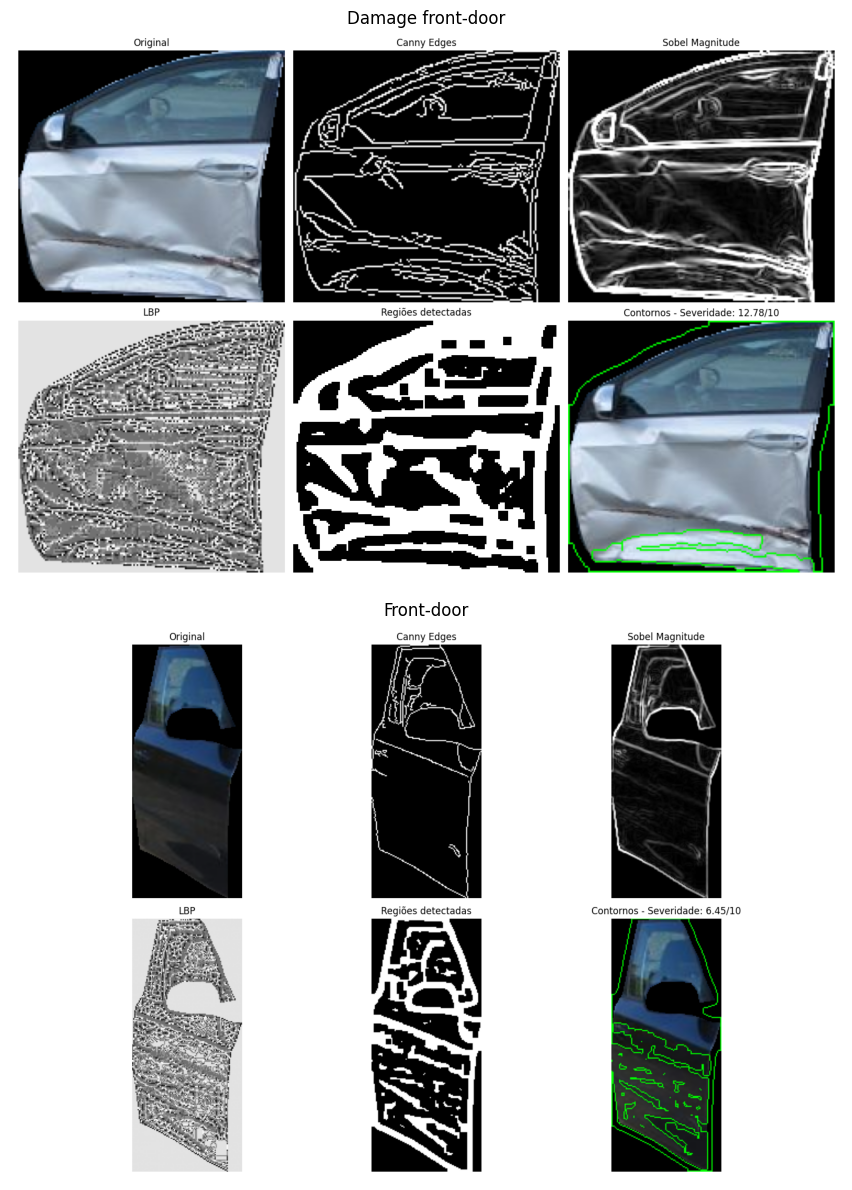

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(16, 12))
axes = axes.flatten()

image = Image.open("/content/output/100_0_resultado.png")
axes[0].imshow(image)
axes[0].set_title("Damage front-door")
axes[0].axis('off')

image = Image.open("/content/output/101_0_resultado.png")
axes[1].imshow(image)
axes[1].set_title("Front-door")
axes[1].axis('off')

plt.tight_layout()
plt.show()